## ArcticHeat Alamo Deployments:
** 2018 **

__pyversion__==3.6   
__author__==S.Bell

### connecting and basic information

In [10]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

server_url='http://downdraft.pmel.noaa.gov:8080/erddap'
e = ERDDAP(server=server_url)

Get only ALAMO Float datafiles

In [11]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='ALAMO'))

In [12]:
alamos = df['Dataset ID'].values
print(alamos)

['arctic_heat_alamo_profiles_9058' 'arctic_heat_alamo_profiles_9076'
 'arctic_heat_alamo_profiles_9085' 'arctic_heat_alamo_profiles_9115'
 'arctic_heat_alamo_profiles_9116' 'arctic_heat_alamo_profiles_9117'
 'arctic_heat_alamo_profiles_9119' 'arctic_heat_alamo_profiles_9150'
 'arctic_heat_alamo_profiles_9152' 'arctic_heat_alamo_profiles_9153']


In [13]:
kw = {
    'standard_name': 'sea_water_temperature',
    'min_lon': -180.0,
    'max_lon': -130.0,
    'min_lat': 65.0,
    'max_lat': 90.0,
    'min_time': '2018-01-10T00:00:00Z',
    'max_time': '2019-01-10T00:00:00Z',
    'cdm_data_type': 'trajectoryprofile'
}

In [14]:
variables = [e.get_var_by_attr(dataset_id=alamo, standard_name=lambda v: v is not None) for alamo in alamos]

common_variables = set(variables[0]).intersection(*variables[1:])

common_variables 

{'JULD', 'PRES', 'PSAL', 'TEMP', 'latitude', 'longitude', 'time'}

In [15]:
constraints = {
    'longitude>=': kw['min_lon'],
    'longitude<=': kw['max_lon'],
    'latitude>=': kw['min_lat'],
    'latitude<=': kw['max_lat'],
    'time>=': kw['min_time'],
    'time<=': kw['max_time'],
}

download_url = e.get_download_url(
    dataset_id=alamos[0],
    protocol='tabledap',
    response='csv',
    variables=common_variables,
    constraints=constraints
)

print(download_url)

http://downdraft.pmel.noaa.gov:8080/erddap/tabledap/arctic_heat_alamo_profiles_9058.csv?PRES,longitude,JULD,latitude,time,PSAL,TEMP&longitude>=-180.0&longitude<=-130.0&latitude>=65.0&latitude<=90.0&time>=1515542400.0&time<=1547078400.0


### retrieving erddap and plotting data

In [17]:
from requests.exceptions import HTTPError

dfs = {}
for alamo in alamos:
    print(alamo)
    try:
        e = ERDDAP(server=server_url,
            protocol='tabledap',
            response='csv'
        )
        e.constraints=constraints
        e.variables=common_variables
        e.dataset_id=alamo
    except HTTPError:
        print('Failed to generate url {}'.format(alamo))
        continue
    try:
        dfs.update({alamo: e.to_pandas(
                            index_col='time',
                            parse_dates=True,
                            skiprows=(1,)  # units information can be dropped.
                            )})
    except:
        pass

arctic_heat_alamo_profiles_9058
arctic_heat_alamo_profiles_9076
arctic_heat_alamo_profiles_9085
arctic_heat_alamo_profiles_9115
arctic_heat_alamo_profiles_9116
arctic_heat_alamo_profiles_9117
arctic_heat_alamo_profiles_9119
arctic_heat_alamo_profiles_9150
arctic_heat_alamo_profiles_9152
arctic_heat_alamo_profiles_9153


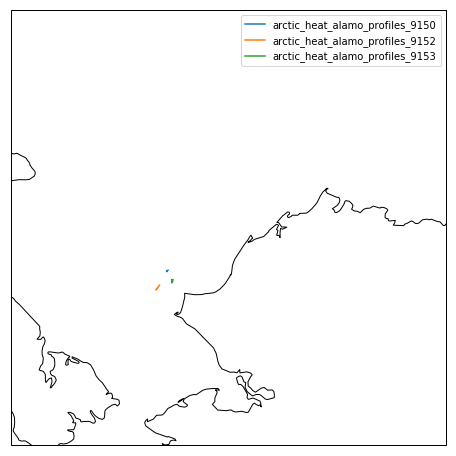

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(8, 8),
                           subplot_kw=dict(projection=projection))
    if projection == ccrs.PlateCarree():
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='1.0')

dx = dy = 0.5
extent = -180, -130, kw['min_lat']+dy, kw['max_lat']+dy
extent = [-176, -150, 65, 75]

fig,ax = make_map(projection=projection)
for alamo, df in dfs.items():
    ax.plot(df['longitude'], df['latitude'], label=alamo, transform=transformation)

leg = ax.legend()

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)

**Todo:** 
- Facets for TvS
- Sfc Temp
- Temp at Depth
- profiles